# Modellbildung und Simulation - Übung 1

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
accData = pd.read_csv("data/Acceleration.csv", sep=";")
pvData = pd.read_csv("data/Pressure_and_velocity.csv", sep=";")

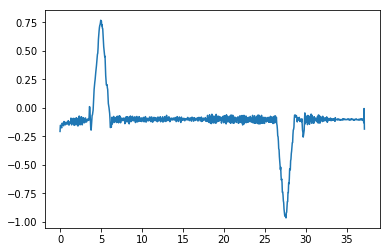

In [4]:
plt.plot(accData['Time (s)'], accData['Acceleration (m/s²)'])

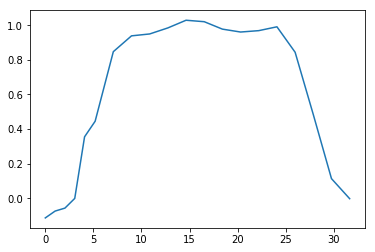

In [5]:
plt.plot(pvData['Time (s)'], pvData['Velocity (m/s)'])

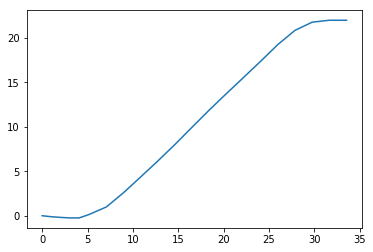

In [6]:
plt.plot(pvData['Time (s)'], pvData['Height (m)'])